In [1]:
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from pylab import *

import pickle
import keras
import loadnotebook
from predictionhelper import *

import warnings
warnings.filterwarnings('ignore')

/home/izza/installdir/miniconda3/envs/stock/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from predictionhelper.ipynb


# Predicted Data Preparation 

In [2]:
x_cut = 50  
y_cut = 100 

old_origin_img = cv2.imread('../image/map.png',0)
crop = old_origin_img[y_cut:318, x_cut:927]
crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)

x_coord_list = []
y_coord_list = []
pci_list = []
for lon in range(0, crop.shape[1]) :
    for lat in range(0, crop.shape[0]) :
        x_coord_list.append(x_cut + lon)
        y_coord_list.append(y_cut + lat)
        
background = get_map_image(black_white=True)
x_coord_view = [lon for lon in x_coord_list]
y_coord_view = [lat for lat in y_coord_list]

all_x_pci = pd.DataFrame({'location_x':x_coord_list, 'location_y':y_coord_list})

# Predict

In [3]:
def add_custom_feature(df, power_val) :
    for p in power_val :
        df["Power_" + str(p)] = power_val[p]
    df = add_distance(df)
    df = add_angle_map(df)
    return df

In [4]:
s = 8
powers = {37:-2, 38:3, 39:0, 40:5, 41:-1, 42:16}
ml_name = 'xgboost'
training_method = 'baseline' #use set 
training_method = 'independent_set_%d' % (s) 
training_method = 'transfer_except_%d' % (s) 
training_method = '20_bayesian_independent_%d' % (s) 

In [5]:
model_name = 'db/%s_%s_%s' % ('PCI', ml_name, training_method)
model = pickle.load(open(model_name + ".pickle.dat", "rb"))

if s is None :
    all_x_data = add_custom_feature(pd.DataFrame(all_x_pci), powers)
else :
    all_x_data = add_features(pd.DataFrame(all_x_pci), 6, s)
    beam_columns = [c for c in all_x_data if "beam" in c]
    all_x_data = all_x_data.drop(beam_columns, axis=1)
    
all_x_data['priority'] = 6
if 'transfer' not in training_method:
    all_x_data['set'] = s if s is not None else 0

In [6]:
proba = False

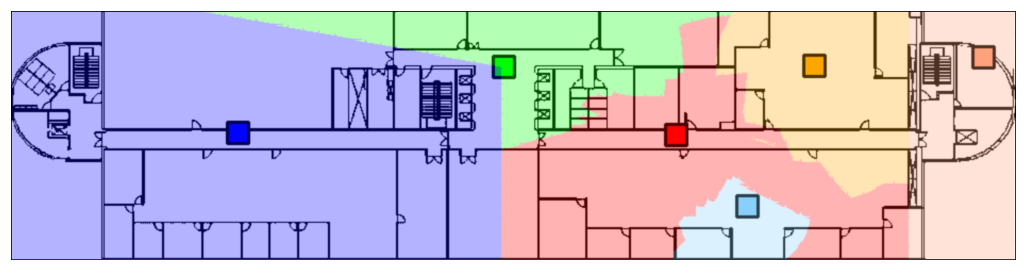

In [7]:
s_name = s if s is not None else 0
if not proba :
    y_pred = model.predict(all_x_data)
    path = "../results/predicted/pci/%s/priority_%d_set_%d.png" % (ml_name, 6, s_name)
    a = visualize_pci_heatmap(background, x_coord_view, y_coord_view, y_pred, path)
else :
    y_pred=model.predict_proba(all_x_data)
    pci_interference = np.max(y_pred, axis=1)
    normalize_pci_interference = matplotlib.colors.Normalize(vmin=min(pci_interference), 
                                                             vmax=max(pci_interference))

    pci_interference = [cmap(normalize_pci_interference(value))[:3] for value in pci_interference]
    pci_interference = [[int(x*255) for x in value] for value in pci_interference]    
    path = "../results/predicted/pci_interference/%s/confidence_pci/priority_%d_set_%d.png" % \
    (ml_name, 6, s_name)
    a=visualize_all_location_heatmap(background, x_coord_view, y_coord_view, pci_interference, 
                                     cmap, normalize_pci_interference, filename=path,
                                     size=1, figsize=(20,10), adjustment=True, show=False)